# cTLM analysis script

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os


from ipywidgets import interact, fixed
import ipywidgets as widgets
from ipyfilechooser import FileChooser

### read files

In [ ]:
# folder_path = r"C:\Uni\Master\Data\TLM\SiC-72"
# folder_path = r"H:\VS_code\CTLM Messdaten\[processname=Blauwal][structure=CTLM][ri=77][description=Block2]"
folder_path = r"C:\Users\lhage\Documents\VSCode\Master_data\Data\CTLM Messdaten\[processname=Blauwal][structure=CTLM][ri=77][description=Block2]"

name = os.path.basename(folder_path)

list_of_measurements = {}
for file in os.listdir(folder_path):
    if file.endswith('.roh'):
        data = pd.read_csv(os.path.join(folder_path, file), delimiter='\t', skiprows=12, header=1, encoding='ISO-8859-1')
        data['delta_V'] = data['VinS'] - data['VoutS']
        list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data

list_of_measurements = dict(sorted(list_of_measurements.items()))
print(list_of_measurements.keys())

dict_keys([4, 24, 44, 94, 140, 160, 180, 200])


### plot all measurements for a quick overview

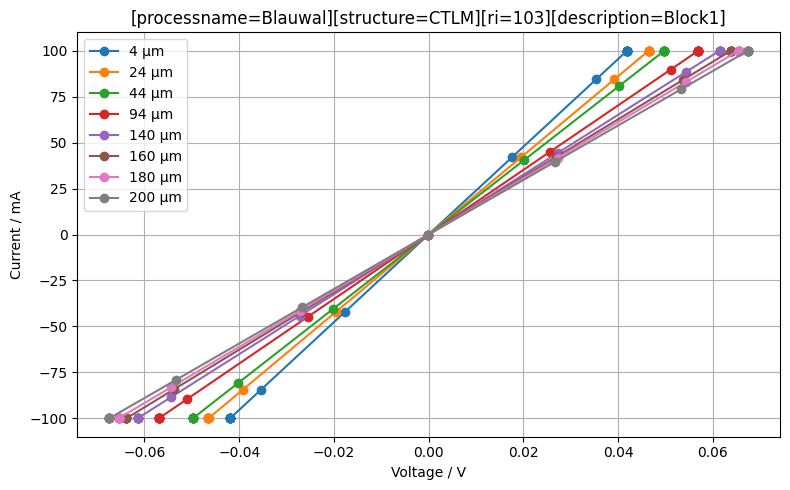

In [87]:
plt.figure(figsize=(8, 5))

for key in list_of_measurements.keys():
    # plt.plot(list_of_measurements[key]['Vin'], list_of_measurements[key]['Iin']*1000, label=key)
    plt.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, 'o-', label=f"{key} µm")

plt.xlabel("Voltage / V")
plt.ylabel("Current / mA")
# plt.xlim(-0.5, 0.5)
plt.title(name)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(folder_path, 'IV.png'), bbox_inches='tight')

In [88]:
def get_lin_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    r_squared = 1- np.sum((y - y_fit)**2)/(np.sum((y - np.mean(y))**2)) # R^2 = 1 - SS_res / SS_tot = 1 - (y-y_fit)^2/(y-mean(y))^2

    return slope, intercept, r_squared

### check lineartiy of individual measuremnts

In [89]:
def plot_IV(key, plot_data):
    plt.figure(figsize=(8, 5))

    plt.plot(plot_data['delta_V'], plot_data['Iin']*1000, label=f"{key} µm")
    slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
    plt.plot(plot_data['delta_V'], (slope * plot_data['delta_V'] + intercept)*1000, 'r--', label=f'linear fit: R² = {r_squared:.3f}')   # *1000 for mA

    plt.xlabel("Voltage / V")
    plt.ylabel("Current / mA")
    plt.title(name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


keys = list(list_of_measurements.keys())
interact(
    lambda key: plot_IV(keys[key], plot_data=list_of_measurements[keys[key]]),
    key=widgets.IntSlider(min=0, max=len(keys)-1, value=0)
)

interactive(children=(IntSlider(value=0, description='key', max=7), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(key)>

### calcualte TLM values

In [90]:
def get_resistance(list_of_measurements, r_inner):
    R_list = []
    R_corr_list = []
    for key in list_of_measurements.keys():
        slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
        R_list.append((1/slope))  # in ohm
        corr_factor = (r_inner / key) * np.log((r_inner + key) / r_inner)
        R_corr_list.append((1/slope)* (1/corr_factor))  # in ohm

    return R_list, R_corr_list

### calculate cTLM values
$L_T$, $R_{sh}$, $R_C$, $\rho_C$


**Fitting Data**

full model: $$ R_{T, \text { circ }}=\frac{R_{s h}}{2 \pi}\left[\ln \left(\frac{r_i+s}{r_i}\right)+\frac{L_t}{r_i} \frac{I_0\left(\frac{r_i}{L_t}\right)}{I_1\left(\frac{r_i}{L_t}\right)}+\frac{L_t}{r_i+s} \frac{K_0\left(\frac{r_i+s}{L_t}\right)}{K_1\left(\frac{r_i+s}{L_t}\right)}\right]$$

Assumtions: 
- radius r2 is small 
- $R_{sh} = R_{sh,c}$ 

simplified: $$R_T=\frac{R_{s h}}{2 \pi}\left[\ln \frac{r_i + d}{r_i}+L_T\left(\frac{1}{r_i +d}+\frac{1}{r_i}\right)\right]$$

$$\begin{split}
R_T &= \mathbf{A} \cdot \ln\left(\frac{r_i + d}{r_i}\right) + \mathbf{B} \cdot \left(\frac{1}{r_i + d} + \frac{1}{r_i}\right)\\
&= A \cdot x_1 + B \cdot x_2
\end{split}$$
$$\mathbf{A} = \frac{R_S}{2\pi}$$
$$\mathbf{B} = \frac{R_S L_T^2}{2\pi}$$

In [96]:
def get_ctlm_params(slope, intercept, r_inner):
    R_sh = slope * 2 * np.pi * r_inner   # in Ohm/sq
    R_C = intercept / 2 # in Ohm
    
    L_T = intercept / slope / 2
    # simple rho_c calculation
    roh_C = (R_sh * (L_T) ** 2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    return R_sh, R_C, L_T, roh_C


# distances, R_list are np.arrays
def complex_ctlm_params(distances, R_list, r_inner):

    R_T = R_list.reshape(-1, 1)  # transpose to column vector
    
    # define column vector for X-matrix
    x1 = np.log((r_inner + distances) / r_inner).reshape(-1, 1)
    x2 = (1/(r_inner + distances) + 1/r_inner).reshape(-1, 1)
    
    X = np.hstack((x1, x2))  # shape (n, 2)
    # print('X_matrix=', X)
    
    # use Linear Least Squares fitting to find the vector [A, B]
    A, B = np.linalg.lstsq(X, R_T, rcond=None)[0]
    
    d_fit = np.arange(0, max(distances), 1)
    # define the fitting function
    R_fit = A * np.log((r_inner + d_fit) / r_inner) + B * (1 / (r_inner + d_fit) + 1 / r_inner) # are those the correct radii?
    
    # get sheet resitance in ohms
    R_sh = A * 2 * np.pi

    # get transfer length in μm
    L_T = (2 * np.pi * B) / R_sh
    
    # get contact resistivity in ohm·μm²
    rho_c = (R_sh * (L_T**2)) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    return d_fit, R_fit, R_sh, L_T, rho_c

### plot TLM

[  4  24  44  94 140 160 180 200]


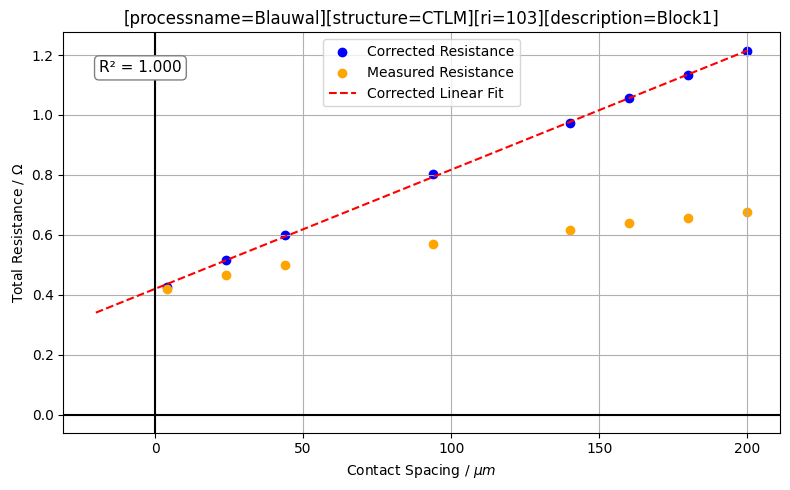


## 🔬 Calculated Physical Properties
### simple correction:
Sheet Resistance (R_sh): 1.9242 Ohms/sq
Contact Resistance (R_C): 0.2098 Ohms
Transfer Length (L_T): 52.7538 μm
Contact Resistivity (rho_C): 5.35e-05 Ohm·cm²


In [ ]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)
print(distances)

R_list, R_corr_list = get_resistance(list_of_measurements, r_inner=77)  

# plt.scatter(distances, R_corr_list, marker='o', facecolors='none', edgecolors='red', label='Corrected Resistance')
plt.scatter(distances, R_corr_list,  color='blue', marker='o', label='Corrected Resistance')
plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')

slope, intercept, r_squared = get_lin_fit(distances, R_corr_list)
R_sh, R_C, L_T, roh_C = get_ctlm_params(slope, intercept, r_inner=77)

x_fit_extended = np.linspace(-20, distances.max(), 200)
plt.plot(x_fit_extended, (slope * x_fit_extended + intercept), 'r--', label='Corrected Linear Fit')

plt.gca().text(
    0.05, 0.9, f"R² = {r_squared:.3f}",
    fontsize=11,
    transform=plt.gca().transAxes,
    # verticalalignment='bottom',
    # horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')    # alpha=0.8
)
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)


plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
plt.show()


print("\n## 🔬 Calculated Physical Properties")
print('### simple correction:')
print(f"Sheet Resistance (R_sh): {R_sh:.4f} Ohms/sq")
print(f"Contact Resistance (R_C): {R_C:.4f} Ohms")
print(f"Transfer Length (L_T): {L_T:.4f} μm")
print(f"Contact Resistivity (rho_C): {roh_C:.2e} Ohm·cm²")

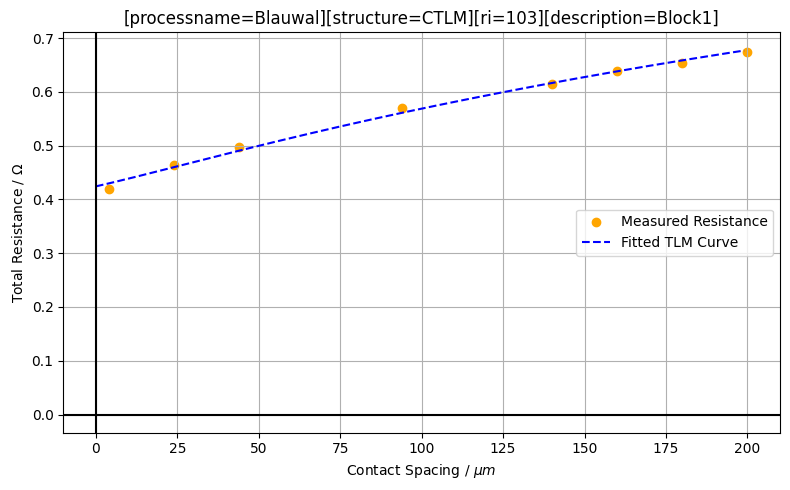


## 🔬 Calculated Physical Properties
### complex model:
Sheet Resistance (R_sh): 1.9963 Ohms/sq
Transfer Length (L_T): 51.4144 μm
Contact Resistivity (rho_C): 5.28e-05 Ohm·cm²


In [94]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)

R_list, R_corr_list = get_resistance(list_of_measurements, r_inner=103)  

plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')

d_fit, R_fit, R_sh_complex, L_T_complex, rho_C_complex = complex_ctlm_params(distances, np.array(R_list), 77)

plt.plot(d_fit, R_fit, color='blue', linestyle='--', label='Fitted TLM Curve')

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
plt.show()


print("\n## 🔬 Calculated Physical Properties")
print('### complex model:')
print(f"Sheet Resistance (R_sh): {R_sh_complex[0]:.4f} Ohms/sq")
# print(f"Contact Resistance (R_C): {R_C_complex[0]:.4f} Ohms")
print(f"Transfer Length (L_T): {L_T_complex[0]:.4f} μm")
print(f"Contact Resistivity (rho_C): {rho_C_complex[0]:.2e} Ohm·cm²")